In [1]:
import torch
import os
import json
import tqdm
import collections
import random
import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection
import scipy

According to Kohonen, we can do about 50 datapoints per node. For 3.5k that means maybe 60-80 nodes.
I want a 5x4 resolution for display reasons, so maybe 10x8 nodes?

In [2]:
fnames = os.listdir("data")
fields = ['name','smiles','notes']
molecules = []
for fname in tqdm.tqdm(fnames):
    with open(os.path.join("data",fname)) as f:
        mol = json.load(f)
        data = {k:mol[k] for k in fields}
        # Check that the molecule has all the fields of interest
        if all(data.values()):
            molecules.append(data)

# Have to de-dupe the notes for each molecule.
for mol in molecules:
    mol["notes"] = set(mol["notes"])
    
print(f"Found {len(molecules)} molecules.")
molecules[:3]

100%|███████████████████████████████████| 19194/19194 [00:02<00:00, 6881.35it/s]

Found 3440 molecules.


[{'name': 'amyl butyrate',
  'smiles': 'CCCCCOC(=O)CCC',
  'notes': {'banana', 'cherry', 'fruity', 'pineapple', 'sweet', 'tropical'}},
 {'name': 'para-anisyl phenyl acetate',
  'smiles': 'COC1=CC=C(C=C1)COC(=O)CC2=CC=CC=C2',
  'notes': {'anise', 'balsamic', 'honey', 'woody'}},
 {'name': 'dihydrofarnesol',
  'smiles': 'CC(CC/C=C(\\C)/CCC=C(C)C)CCO',
  'notes': {'cyclamen', 'floral', 'metallic'}}]

In [3]:
all_notes = collections.Counter()
for mol in molecules:
    all_notes.update(mol["notes"])
print(f"Found {len(all_notes)} unique notes.")
print("Most common:")
print(all_notes.most_common(5))

Found 502 unique notes.
Most common:
[('fruity', 1060), ('green', 967), ('sweet', 884), ('floral', 706), ('woody', 558)]


In [4]:
all_notes_list = list(all_notes.keys())

def multi_hot(notes):
    indices = torch.tensor([all_notes_list.index(n) for n in notes])
    if len(indices) == 0:
        # Occurs when the notes in the pair were removed due to infrequency.
        raise AttributeError("Found no valid notes.")
    one_hots = torch.nn.functional.one_hot(indices, len(all_notes))
    return one_hots.sum(dim=0).float()

for mol in molecules:
    mol["encoding"] = multi_hot(mol["notes"])

print(molecules[0])

{'name': 'amyl butyrate', 'smiles': 'CCCCCOC(=O)CCC', 'notes': {'tropical', 'pineapple', 'banana', 'sweet', 'fruity', 'cherry'}, 'encoding': tensor([1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [5]:
def flatten(mtrx):
    return mtrx.reshape((mtrx.shape[0]*mtrx.shape[1],-1)).squeeze()

In [6]:
def get_idx_grid(width,height,step):
    x_idx, y_idx = torch.meshgrid(torch.arange(start=0,end=width-1+step,step=step), torch.arange(start=0,end=height-1+step,step=step), indexing='ij')
    grid_idx = torch.stack([x_idx,y_idx],dim=-1)
    return flatten(grid_idx)

In [7]:
class SOM(object):
    def __init__(self,width,height,gauss=10,decay=.99,use_onehot=True):
        if use_onehot:
            # Select a random index to use as the hot element.
            idxs = torch.randint(low=0,high=len(all_notes),size=(width,height))
            # Convert to one hot of shape.
            self.vectors = torch.nn.functional.one_hot(idxs,num_classes=len(all_notes)).float()
        else:
            self.vectors = torch.nn.functional.normalize(torch.rand(size=(width,height,len(all_notes))).float(),dim=-1)
        
        self.gauss = gauss
        self.decay = decay
        self.width = width
        self.height = height

        self.vectors = flatten(self.vectors)
        self.map_idx = get_idx_grid(width,height,1)

    def do_decay(self):
        # From the author:
        # For large SOMs, the final value of σ may be on the order of five per cent of the shorter side of the grid.
        # For smaller ones, idk.
        min_gauss = min(self.width,self.height)*.05
        self.gauss *= self.decay
        self.gauss = max(self.gauss,min_gauss)

    def get_activations(self,encoding):
        # Activation is 1 / Euclidian(vectors, encoding).
        # The closer a vector is to the encoding, the higher the activation.
        return 1/(self.vectors-encoding).square().sum(dim=-1).sqrt()

    def get_enc_dists(self,encoding):
        # Activation is 1 / Euclidian(vectors, encoding).
        # The closer a vector is to the encoding, the higher the activation.
        return (self.vectors-encoding).square().sum(dim=-1).sqrt()

    def get_bmu(self,encoding):
        actvtn = self.get_activations(encoding)
        # Especially at the beginning of training, there may be a larger amount
        # of vectors that are equidistant to the encoding. 
        bmu_idxs = (actvtn==torch.max(actvtn)).nonzero()
        # In order to prevent embedding collapse, we select one randomly as the bmu.
        selected = np.random.randint(low=0,high=len(bmu_idxs))
        # print(bmu_idxs,bmu_idxs[selected])
        return bmu_idxs[selected]

    def get_bmu_pos(self,encoding):
        return self.map_idx[self.get_bmu(encoding)]

    def mean_encoding_by_bmu(self,encodings,bmus):
        # https://stackoverflow.com/questions/56154604/groupby-aggregate-mean-in-pytorch/56155805#56155805
        M = torch.zeros(len(self.vectors), len(encodings))
        M[bmus, torch.arange(len(encodings))] = 1
        M = torch.nn.functional.normalize(M, p=1, dim=1)
        return torch.mm(M, encodings)

    def get_distances(self):
        # Distance from each node to every other node
        xy_dist = self.map_idx.unsqueeze(0) - self.map_idx.unsqueeze(1)
        return torch.sqrt(torch.sum(torch.square(xy_dist),dim=-1))

    def get_intra_vector_dist_range(self):
        xy_dist = self.vectors.unsqueeze(0) - self.vectors.unsqueeze(1)
        dists = torch.sqrt(torch.sum(torch.square(xy_dist),dim=-1))
        # We want to get the minimum distance from a vector to any OTHER vector,
        # so we need to ignore the 0 distances (which are from a vector to itself).
        return torch.min(dists[dists>0]), torch.max(dists)
    
    def get_intra_vector_activation_range(self):
        xy_dist = self.vectors.unsqueeze(0) - self.vectors.unsqueeze(1)
        dists = torch.sqrt(torch.sum(torch.square(xy_dist),dim=-1))
        # We want to get the minimum distance from a vector to any OTHER vector,
        # so we need to ignore the 0 distances (which are from a vector to itself).
        # Activations are just inverse of distance.
        return 1/torch.max(dists), 1/torch.min(dists[dists>0])

    def update_factor(self):
        dists = self.get_distances()
        return torch.exp(torch.neg(torch.div(dists.square(), 2*self.gauss**2)))

    def batch_sum_encodings(self,bmus,encodings):
        # Although this is referred to as h_ji in the paper
        # it is symmetric (so h[j][i] == h[i][j])
        h_ij = self.update_factor()
        x_mj = self.mean_encoding_by_bmu(encodings,bmus)
        
        bmu_count_by_idx = torch.bincount(bmus, minlength=len(self.map_idx))
        # Unsqueeze the first dimension of the counts so that the update factor
        # for i to j is weighted based on occurences of j.
        weighted_h_ji = bmu_count_by_idx.unsqueeze(0)*h_ij

        return torch.mm(weighted_h_ji, x_mj)/weighted_h_ji.sum(dim=-1,keepdim=True)

    def update_batch(self,encodings):
        # This step is not vectorized, but we could do a random partitioning or something above.
        bmus = torch.cat([self.get_bmu(e) for e in encodings])
        self.vectors = torch.nn.functional.normalize(self.batch_sum_encodings(bmus,encodings),dim=-1)
        
def test():
    mm = SOM(3,2)
    encodings = torch.stack([mol["encoding"] for mol in molecules[:10]])
    mm.update_batch(encodings)

test()

In [8]:
class SOM__(object):
    def __init__(self,som):
        self.vectors = som.vectors
        self.map_idx = som.map_idx
        self.gauss = som.gauss

    def get_activations(self,encoding):
        # Activation is 1 / Euclidian(vectors, encoding).
        # The closer a vector is to the encoding, the higher the activation.
        return 1/(self.vectors-encoding).square().sum(dim=-1).sqrt()

    def get_bmu(self,encoding):
        actvtn = self.get_activations(encoding)
        # Especially at the beginning of training, there may be a larger amount
        # of vectors that are equidistant to the encoding. 
        bmu_idxs = (actvtn==torch.max(actvtn)).nonzero()
        # In order to prevent embedding collapse, we select one randomly as the bmu.
        selected = np.random.randint(low=0,high=len(bmu_idxs))
        return bmu_idxs[selected]

    def mean_encoding_by_bmu__(self,encodings,bmus):
        sum_mj = torch.zeros(self.vectors.shape)
        count_mj = torch.zeros(self.vectors.shape[0])
        for i, v_idx in enumerate(bmus):
            count_mj[v_idx] += 1
            sum_mj[v_idx] += encodings[i]

        x_mj = torch.zeros(self.vectors.shape)
        for i, sm in enumerate(sum_mj):
            if count_mj[i] > 0:
                x_mj[i] = sm / count_mj[i]
            else:
                x_mj[i] = torch.zeros(sm.shape)

        return x_mj

    def update_factor__(self):
        uf = torch.empty((len(self.map_idx),len(self.map_idx)))
        for i, p1 in enumerate(self.map_idx):
            for j, p2 in enumerate(self.map_idx):
                xy_dist = p1 - p2
                d = torch.sqrt(torch.sum(torch.square(xy_dist),dim=-1))
                uf[i][j] = torch.exp(torch.neg(torch.div(d.square(), 2*self.gauss**2)))
        return uf

    def batch_sum_encodings__(self,bmus,encodings):
        h_ij = self.update_factor__()
        x_mj = self.mean_encoding_by_bmu__(encodings,bmus)

        bmu_count_by_idx = torch.zeros(self.vectors.shape[0])
        for i, v_idx in enumerate(bmus):
            bmu_count_by_idx[v_idx] += 1

        bse = torch.zeros(self.vectors.shape)
        for i in range(len(h_ij)):
            denom = torch.zeros(bmu_count_by_idx.shape)
            for j in range(len(h_ij)):
                bse[i] += x_mj[j] * h_ij[i][j] * bmu_count_by_idx[j]
                denom[i] += h_ij[i][j] * bmu_count_by_idx[j]
            
            if denom[i] > 0:
                bse[i] = bse[i] / denom[i]
            else:
                bse[i] = torch.zeros(bse[i].shape)

        return bse
            
        
def test():
    mm = SOM(3,2)
    mm__ = SOM__(mm)
    encodings = torch.stack([mol["encoding"] for mol in molecules[:10]])
    bmus = torch.cat([mm.get_bmu(e) for e in encodings])

    assert torch.all(mm.vectors==mm__.vectors)

    def test_update_factor():
        nonlocal mm, mm__
        h_ij = mm.update_factor()
        h_ij__ = mm__.update_factor__()
        assert torch.isclose(h_ij,h_ij__).all()

    def test_update_factor_symmetric():
        nonlocal mm, mm__, bmus
        h_ij__ = mm__.update_factor__()
        for i in range(len(h_ij__)):
            for j in range(len(h_ij__)):
                assert h_ij__[i][j] == h_ij__[j][i]
            
    def test_mean_encoding_by_bmu():
        nonlocal mm, mm__, bmus, encodings
        x_mj = mm.mean_encoding_by_bmu(encodings,bmus)
        x_mj__ = mm__.mean_encoding_by_bmu__(encodings,bmus)
        assert torch.isclose(x_mj,x_mj__).all()

    def test_batch_sum_encodings():
        nonlocal mm, mm__, bmus, encodings
        # bmus are selected randomly, so we inject them here
        bse = mm.batch_sum_encodings(bmus,encodings)
        bse__ = mm__.batch_sum_encodings__(bmus,encodings)
        assert torch.isclose(bse,bse__).all()
    
    test_update_factor()
    test_update_factor_symmetric()
    test_mean_encoding_by_bmu()
    test_batch_sum_encodings()
    

test()

In [9]:
def get_distribution(som,use_freq=False):
    d = torch.zeros(len(som.map_idx))
    for n, f in all_notes.most_common():
        bmu = som.get_bmu(multi_hot([n]))
        if use_freq:
            d[bmu] += f
        else:
            d[bmu] += 1
    return d

def make_histogram(som,use_freq=False):
    d = get_distribution(som,use_freq)
    plt.stairs(d,fill=True)
    plt.show()



In [96]:
len(molecules)/50

68.8

100%|███████████████████████████████████████████| 20/20 [00:02<00:00,  9.04it/s]

tensor(582.0903) 0.24315330918113873


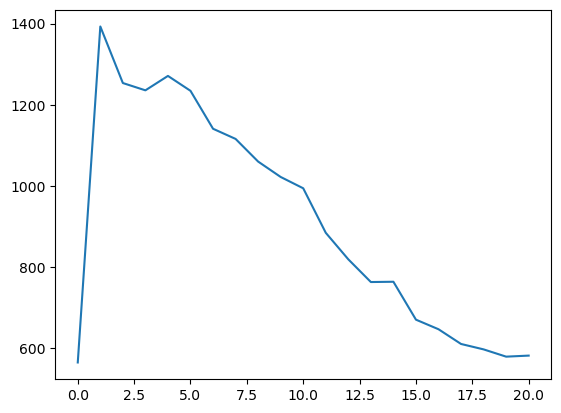

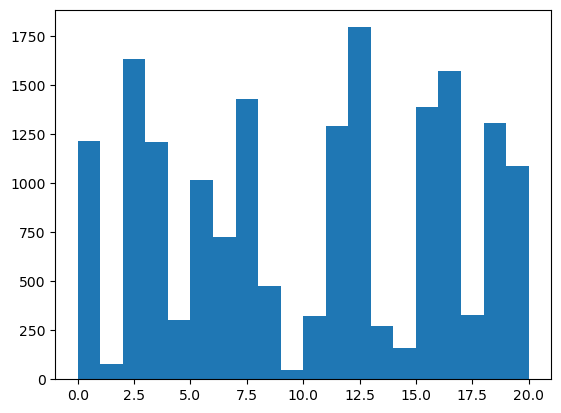

In [122]:
train_mols, test_mols = sklearn.model_selection.train_test_split(molecules)

def do_train(config,verbose=False):
    som = SOM(width=config["width"],
              height=config["height"],
              gauss=config["gauss"],
              decay=config["decay"],
              use_onehot=config["onehot"])

    def get_score():
        return get_distribution(som,True).std()
    
    encodings = torch.stack([mol["encoding"] for mol in molecules])
    scores = [get_score()]

    steps = int(config["width"] * config["height"])
    for i in tqdm.tqdm(range(steps),smoothing=0, disable=not verbose):
        som.update_batch(encodings)
        som.do_decay()
        scores.append(get_score())

    return som, scores

w = 5
h = 4
# In general, the larger the initial gauss, the longer the training will have to be
# Though using a stronger decay reduces this.
# A larger initial gauss does tend to lead to better distributions, though.
som,scores = do_train({'width': w, 'height': h, "gauss":min(w,h)/2, "decay": .9, "onehot": True},verbose=True)
note_encodings = torch.stack([multi_hot([n]) for n,f in all_notes.most_common()])
all_activations = torch.stack([som.get_activations(enc) for enc in note_encodings])
amin, amax = all_activations.min(), all_activations.max()

# In general the decay doesn't seem to affect final score?
# We just get there slightly faster. To get around this I'll used steps = w * h
# I'll stick to decay = .9 for now (and NOT PLAY WITH IT)

# In order to have any actual hparam tuning we'd need to just make a somewhat exhausting search.
# Hparams I do not want to search
# Steps (reaches a stable state after a while)
# Decay (doesn't seem to effect the final result, just how long to get there)
# For most gauss, steps = w*h and decay = 0.9 seems to eventually reach steady state.

# Hparams I do want to search
# W, H (fixed by suggestion of author, but I could change
# gauss (I'd suggest something like tuning n where gauss = min(w,h)*n
# onehot (But maybe doesn't really do that much)
# Normalizing models/vectors (I think doing this makes a huge difference)
# Min gauss ?

# One issue is that bmu distribution of notes doesn't seem to capture everything?
# Maybe distribution unweighted of molecules and notes?

print(scores[-1],som.gauss)
plt.plot(scores)
plt.show()

make_histogram(som,True)

In [123]:
for n, f in all_notes.most_common(15):
    print(n,som.get_bmu_pos(multi_hot([n])))

fruity tensor([[0, 0]])
green tensor([[2, 3]])
sweet tensor([[3, 0]])
floral tensor([[4, 0]])
woody tensor([[4, 2]])
herbal tensor([[3, 3]])
fresh tensor([[3, 3]])
fatty tensor([[1, 3]])
waxy tensor([[1, 2]])
spicy tensor([[4, 3]])
rose tensor([[4, 0]])
citrus tensor([[1, 3]])
earthy tensor([[0, 2]])
tropical tensor([[1, 1]])
oily tensor([[1, 3]])


In [124]:
for mol in molecules[:15]:
    print(mol["name"],som.get_bmu_pos(mol["encoding"]))

amyl butyrate tensor([[2, 0]])
para-anisyl phenyl acetate tensor([[4, 2]])
dihydrofarnesol tensor([[4, 0]])
(Z)-alpha-damascone tensor([[1, 0]])
methyl phenyl acetate tensor([[1, 0]])
dihydro-alpha-ionone tensor([[4, 1]])
(S)-2-methyl butyraldehyde tensor([[0, 0]])
allyl 10-undecenoate tensor([[1, 2]])
saffron indenone tensor([[4, 2]])
phenyl acetaldehyde dimethyl acetal tensor([[2, 2]])
ethyl (R)-2-hydroxy-4-methyl pentanoate tensor([[3, 3]])
(Z)-3-hexen-1-yl lactate tensor([[2, 1]])
heptyl octanoate tensor([[1, 2]])
10-undecen-2-one tensor([[1, 3]])
isobutyl hexanoate tensor([[1, 1]])


In [125]:
def plot(title,encoding,as_size,factor=1,thresh=1e-5,activations=None):
    bmu = som.get_bmu(encoding)
    if not torch.is_tensor(activations):
        activations = som.get_activations(encoding)

    act = (activations - amin) / (amax - amin)
    minv, maxv = act.min().numpy(), act.max().numpy()
    assert act[bmu].item() == maxv

    pos = som.map_idx.numpy()
    act = torch.nn.functional.threshold(act,thresh,0)
    display_val = (act**2)
    if as_size:
        # For very very small values, matplotlib will underflow and draw circles where it should draw tiny circles.
        print(display_val.min(),display_val.max())
        plt.scatter(pos[:,0],pos[:,1],s=factor*display_val.numpy())
    else:
        plt.scatter(pos[:,0],pos[:,1],c=factor*display_val.numpy())
        plt.set_cmap('PiYG_r')
        plt.colorbar()

    plt.title(f"{title}\nBMU of {bmu.numpy()} w/ value = {act[bmu].item():.2f}. Range = ({minv:.2f}, {maxv:.2f})")



tensor(0.) tensor(0.)


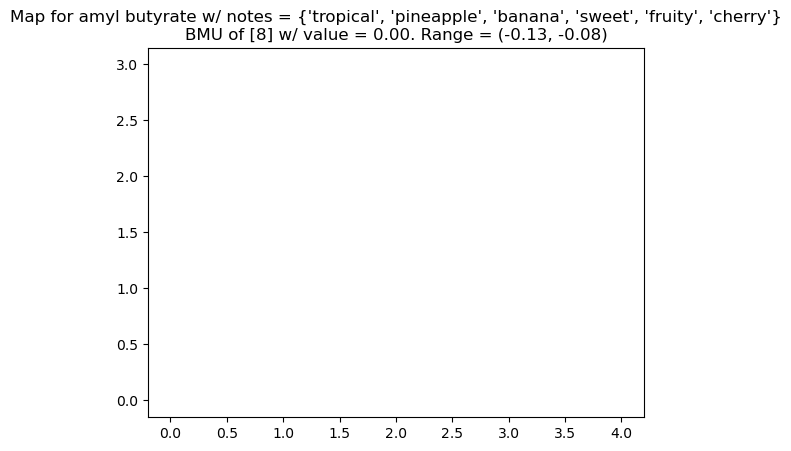

In [126]:
plot(f"Map for {molecules[0]['name']} w/ notes = {molecules[0]['notes']}",
     molecules[0]["encoding"],
     as_size=True,
     factor=1000,
     thresh=1e-2)

plt.show()

In [127]:
def interpolate_activation(step,activations,method="linear"):
    global w,h
    fine_grid = get_idx_grid(w,h,step)
    assert len(activations.shape) == 1
    fine_act = scipy.interpolate.griddata(som.map_idx.numpy(),activations.numpy(),fine_grid.numpy(),method=method)
    assert fine_act[0] == activations[0]
    assert torch.all(fine_grid[0] == som.map_idx[0])
    
    assert fine_act[-1] == activations[-1]
    assert torch.all(fine_grid[-1] == som.map_idx[-1])
    
    return fine_grid, torch.FloatTensor(fine_act)
    
fidx,fa = interpolate_activation(.1,all_activations[0])
fidx.shape,fa.shape

(torch.Size([1271, 2]), torch.Size([1271]))

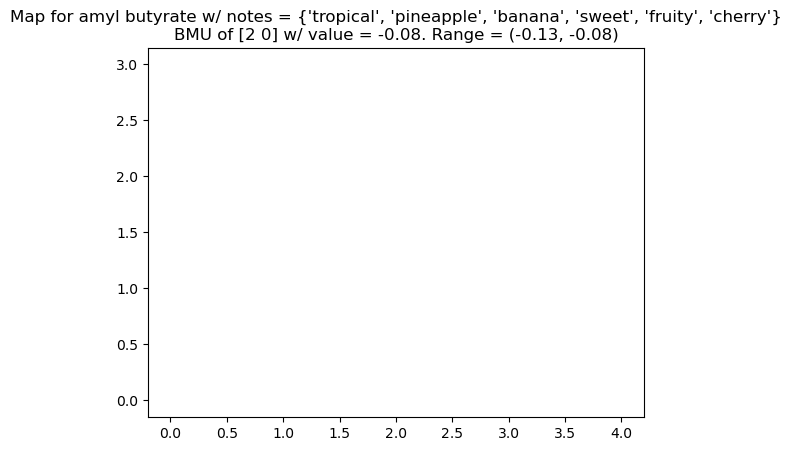

In [128]:
def plot_fine(title,encoding,as_size,step,interpolation,thresh=1e-5,activations=None):
    bmu = som.get_bmu(encoding)
    if not torch.is_tensor(activations):
        activations = som.get_activations(encoding)

    fpos, fact = interpolate_activation(step,activations,method=interpolation)
    act = (fact - amin) / (amax - amin)
    
    minv, maxv = act.min().numpy(), act.max().numpy()
    if interpolation != "cubic":
        # For cubic interpolation, values higher than the previous peak may be created.
        # For linear and nearest this will not happen and we can do this sanity check.
        assert activations[bmu].item() == fact.max()

    # Multiply by step^2 to account for width*height, then again to account for radius of points
    factor = 1e7/(som.width*som.height*(1/(step**3))) 
    act = torch.nn.functional.threshold(act,thresh,0)
    display_val = (act**2)
    if as_size:
        plt.scatter(fpos[:,0],fpos[:,1],s=factor*display_val.numpy())
    else:
        plt.scatter(fpos[:,0],fpos[:,1],c=factor*display_val.numpy())
        plt.set_cmap('PiYG_r')
        plt.colorbar()

    bmu_act = (activations[bmu].item() - amin) / (amax - amin)
    plt.title(f"{title}\nBMU of {som.get_bmu_pos(encoding)[0].numpy()} w/ value = {bmu_act:.2f}. Range = ({minv:.2f}, {maxv:.2f})")

plot_fine(f"Map for {molecules[0]['name']} w/ notes = {molecules[0]['notes']}",
     molecules[0]["encoding"],
     as_size=True,
     thresh=1e-1,
     interpolation="linear",
     step=.01)


plt.show()

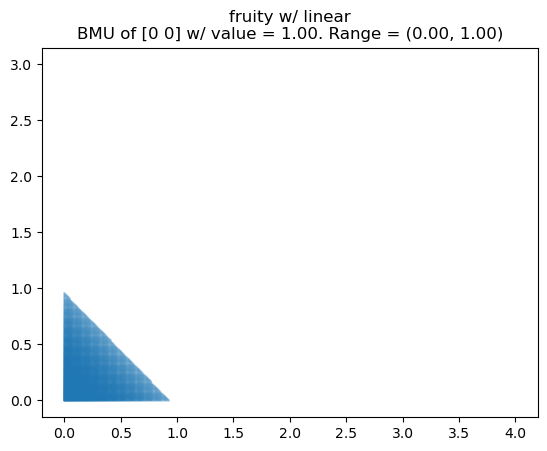

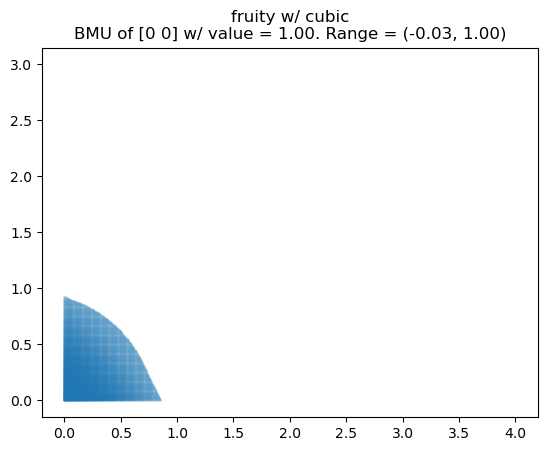

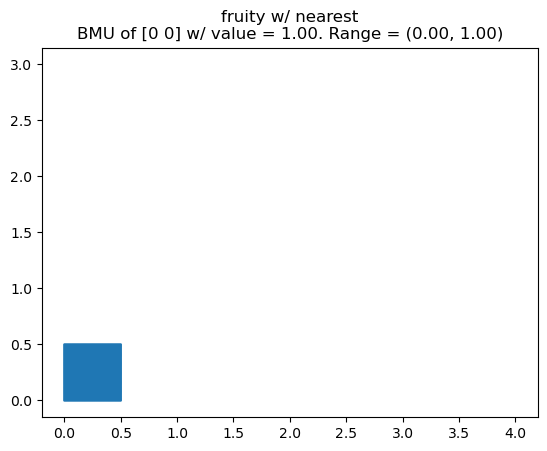

In [129]:
for interp in ["linear","cubic","nearest"]:
    n = "fruity"
    plot_fine(f"{n} w/ {interp}",multi_hot([n]),interpolation=interp,step=.01,as_size=True,thresh=2.5e-1)
    plt.show()
    

In [130]:
# Use this instead of a fixed threshold
# Maybe .5?
all_activations.quantile(.1)

tensor(0.7071)

In my opinion, the color grading in linear is better, but the edges are smoother in cubic.
So I'd like to fix color grading later, but edges are important.

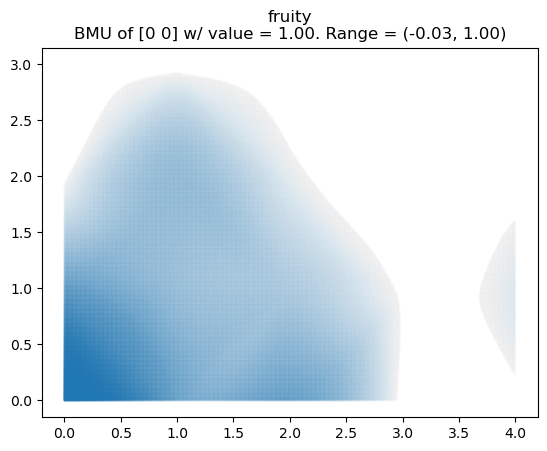

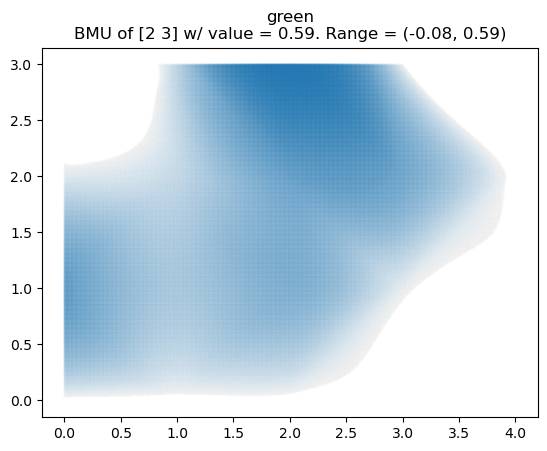

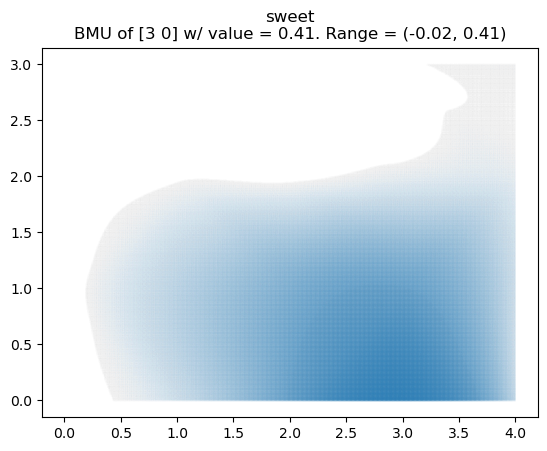

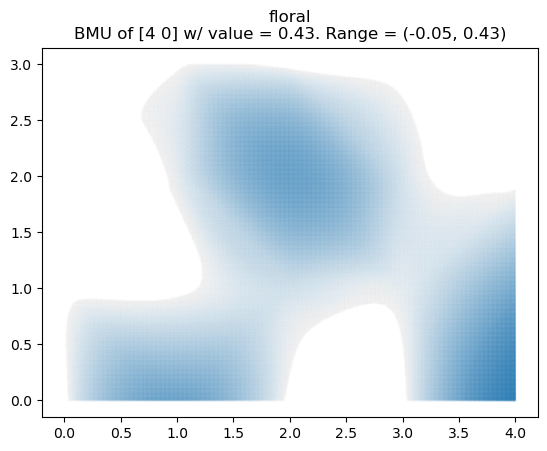

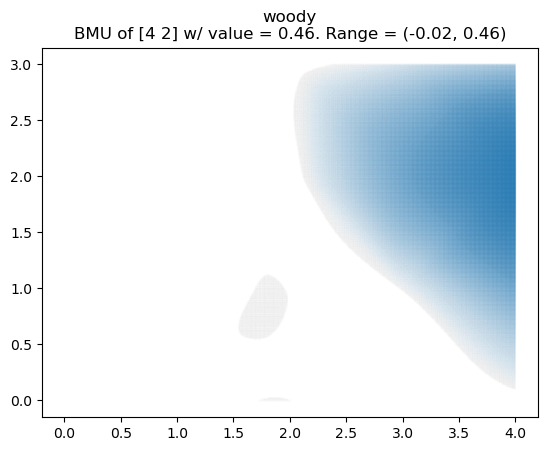

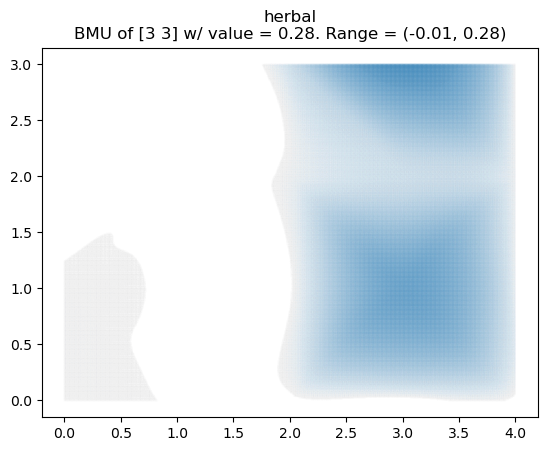

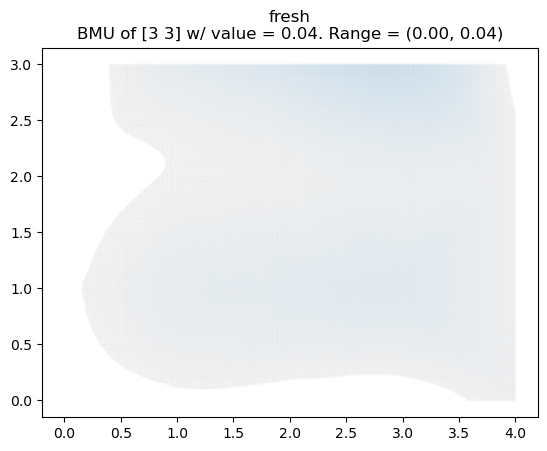

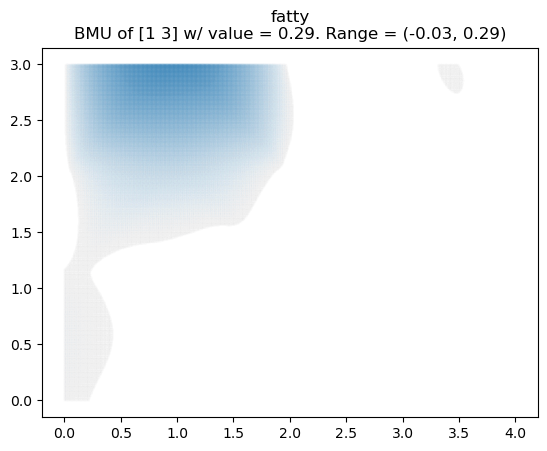

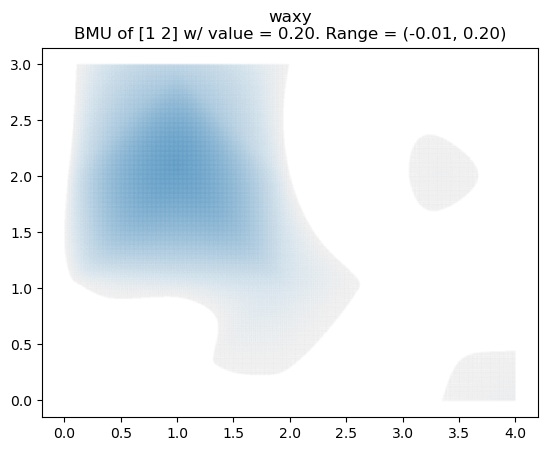

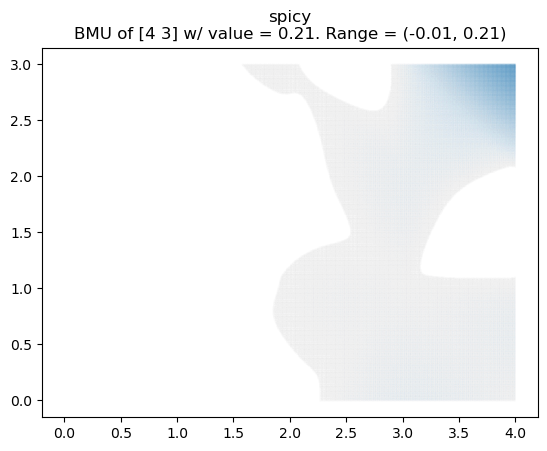

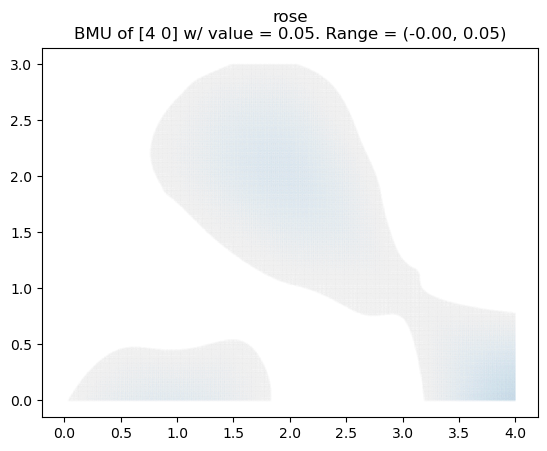

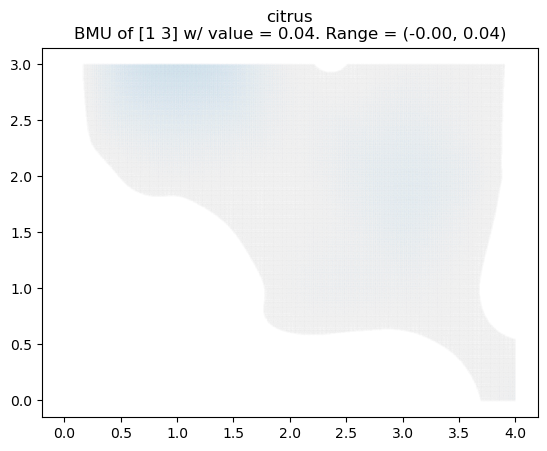

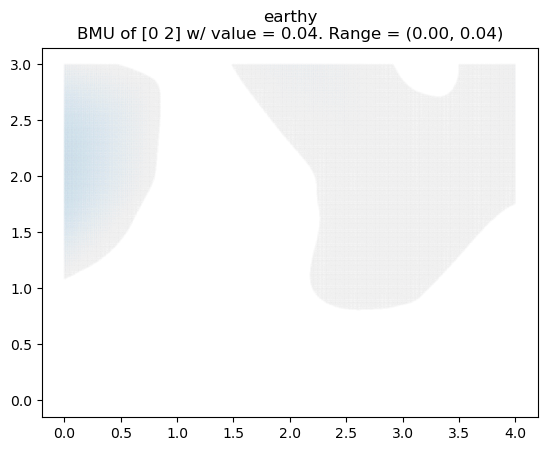

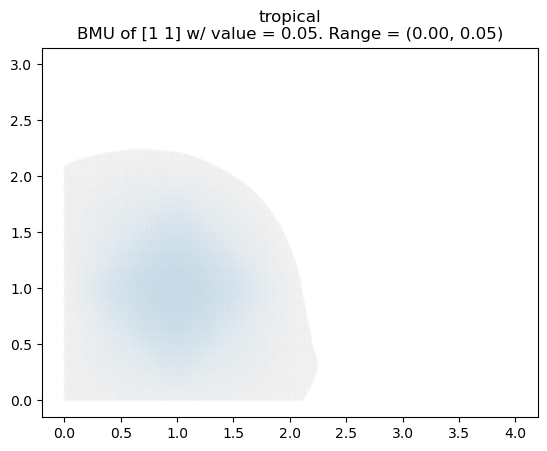

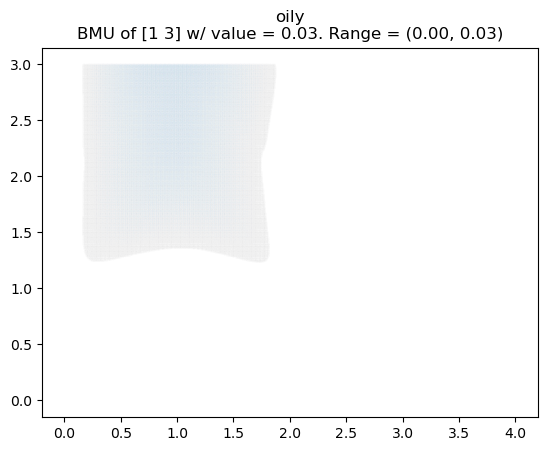

In [143]:
for n, f in all_notes.most_common(15):
    plot_fine(n,multi_hot([n]),interpolation="cubic",step=.005,as_size=True,thresh=1e-2)
    plt.show()


fruity tensor([[0, 0]])
green tensor([[2, 3]])
sweet tensor([[3, 0]])


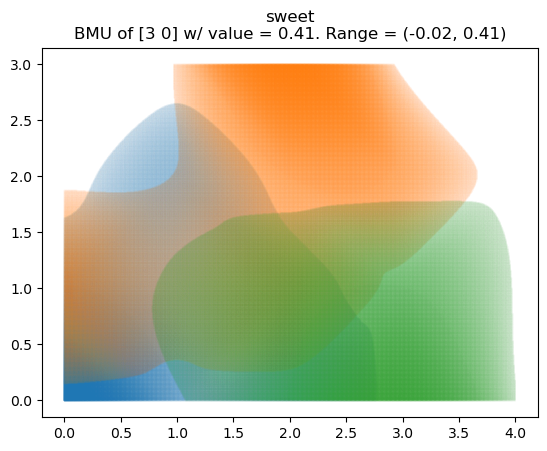

In [140]:
for n, f in all_notes.most_common(3):
    print(n,som.get_bmu_pos(multi_hot([n])))
    plot_fine(n,multi_hot([n]),interpolation="cubic",step=.005,as_size=True,thresh=5e-2)
plt.show()

This doesn't look good because there is no blending, but amazing start.

Ok maybe we can do a floodfill? 
Where we start at the bmu, and we mask based on the threshold, replacing the image with 1
From there we can combine this mask with all the original activations.
If we wanted to, we could even use the tiled image from the cyclic image?
So we get the bmu in the center image and then tile from there? So the edge effect is avoided